# Example
A high dimensional data set has monte carlo integration applied.

Useful because of the ability to backtrack from a model, and identify what metrics are significant indicators of issues.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import OneClassSVM

from highd import HighD

In [2]:
plt.style.use("illumina.mplstyle")

## Preprocessing

Load dataset. The breast cancer data set is used as it has a good number of samples for model training, and a number of dimensions that will result in a significantly difficult to interpret model.

In [3]:
iris = load_breast_cancer()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["species"] = pd.Categorical.from_codes(iris.target, iris.target_names)
print(df["species"].value_counts())
print("Shape:", df.shape)
df.head()

benign       357
malignant    212
Name: species, dtype: int64
Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,species
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


Select (5%) positives then drop species as it is the target; this demonstrates the method dealing with class imbalance.

In [4]:
pos = df[df["species"] == "malignant"][:int(df.shape[0] * 0.05)]
neg = df[df["species"] == "benign"]
df = pd.concat([pos, neg])

Drop species as this is the target.

In [5]:
targets = df["species"]
df = df.drop(["species"], axis=1)

Scale the data.

In [6]:
hd = HighD(df, targets, "malignant", "benign")

Class balance fixed, Negatives: 216 , Positives: 216


In [7]:
# hd.scatter_plot_matrix()

In [8]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    hd.scaled, hd.targets, test_size=0.33, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)
print("F1 score:", f1_score(y_test, preds, pos_label="malignant"))
print("Confusion matrix:")
print(confusion_matrix(y_test, preds))

F1 score: 0.8333333333333333
Confusion matrix:
[[114   1]
 [  3  10]]


## Classifier Training and Analysis

### Random Forests

In [9]:
def rf_clf_func(df):
    proba = rf_clf.predict_proba(df)
    return np.array([i[1] for i in proba])

In [10]:
hd.density_estimate(rf_clf_func, n=10000, k_dens=0.01, n_bins=50)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


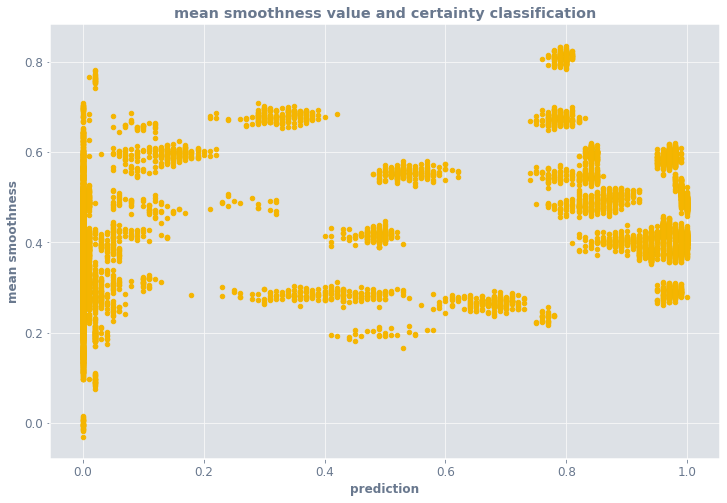

In [11]:
hd.density_scatter("mean smoothness")

Select 5 most important features to visualize.

In [12]:
features = [(f, i) for f, i in zip(X_train.columns, rf_clf.feature_importances_)]   
features.sort(key=lambda x: x[1], reverse=True)
features = [i[0] for i in features[:5]]
print(features)

hd.select_vis_cols(features, n_bins=25)

['worst concave points', 'worst area', 'mean radius', 'worst radius', 'mean concave points']


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


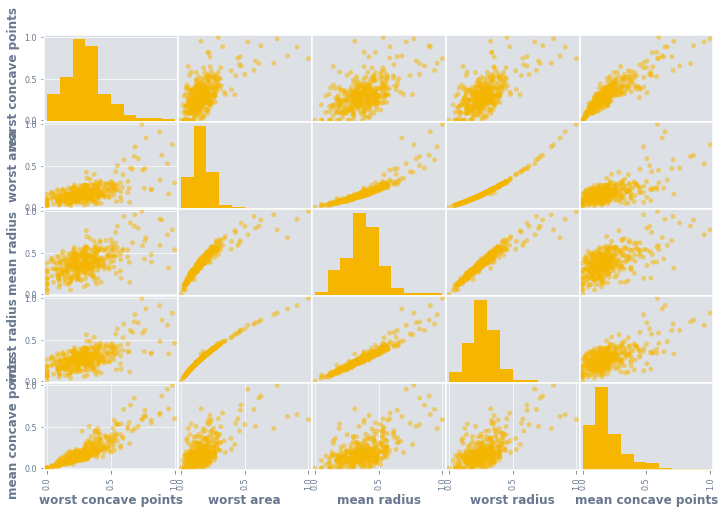

In [13]:
hd.scatter_plot_matrix(features)

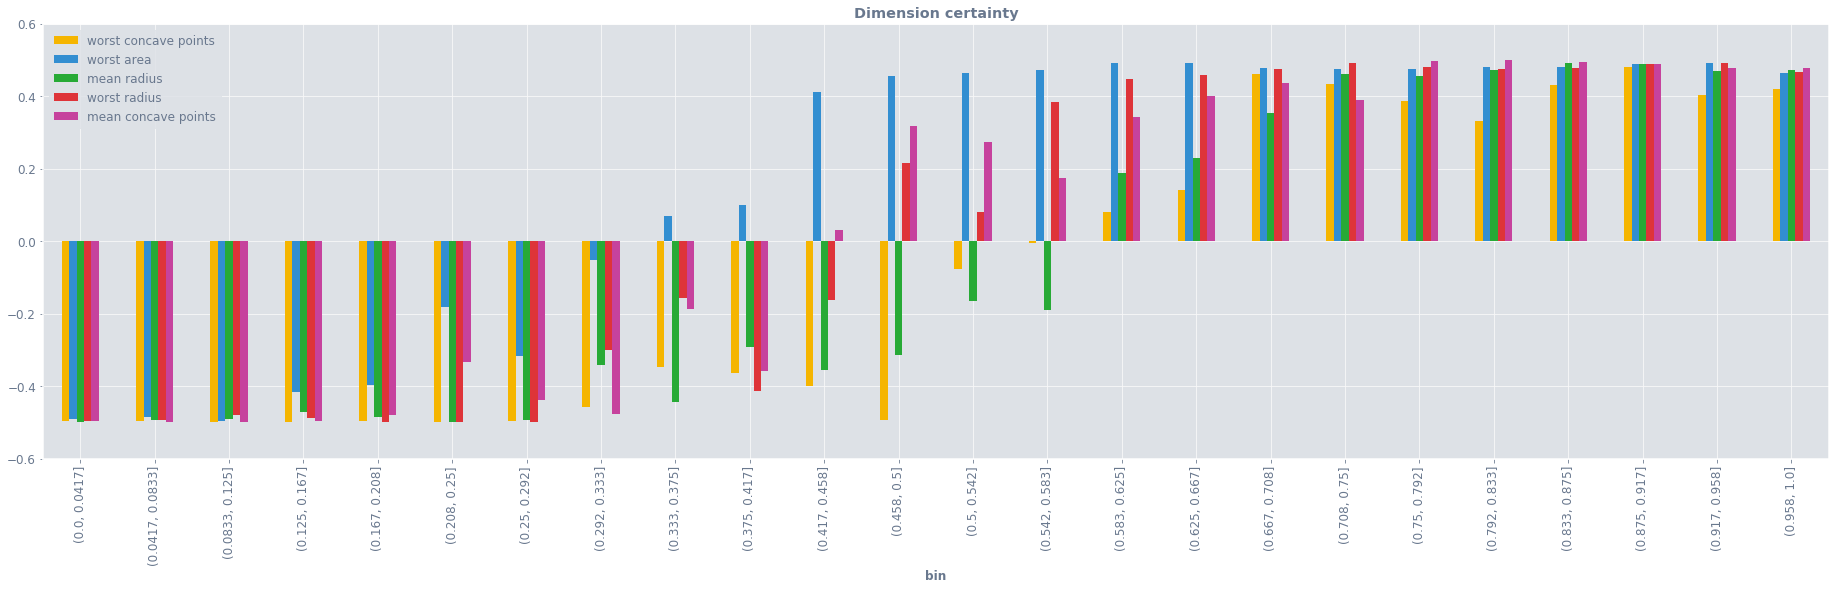

In [14]:
hd.vis_1d(figsize=(32, 8))

Everything red will be classified as malignant, everything blue will be classified as benign.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


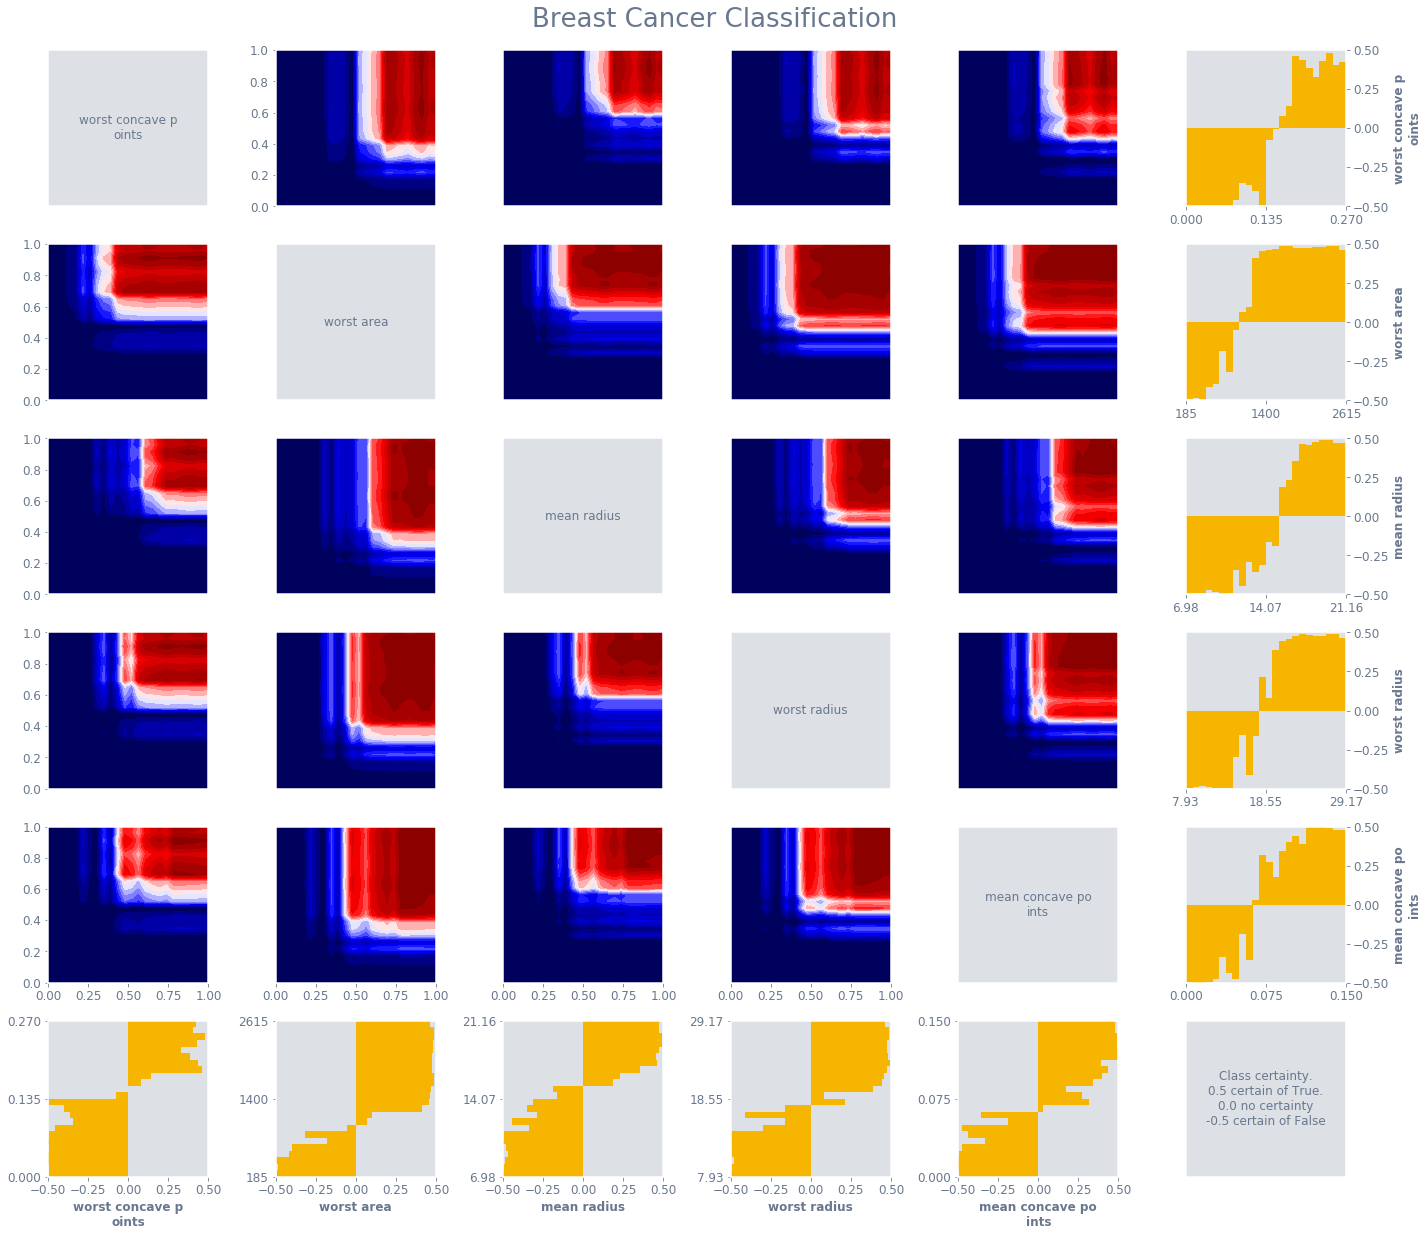

In [15]:
hd.vis_2d(title="Breast Cancer Classification")

### One Class SVM
Used for outlier detection/estimating a learning frontier. The SVM is set to use 10% of points estimated as outliers to set the learning frontier.

In [16]:
oc_clf = OneClassSVM(gamma='auto', nu=0.1).fit(X_train)

In [17]:
def oc_clf_func(df):
    pred = oc_clf.predict(df)
    return [(i + 1) / 2 for i in pred]

In [18]:
tst = oc_clf_func(X_train)
pd.Series(tst).value_counts()

1.0    232
0.0     25
dtype: int64

In [19]:
hd.density_estimate(oc_clf_func, n=10000)

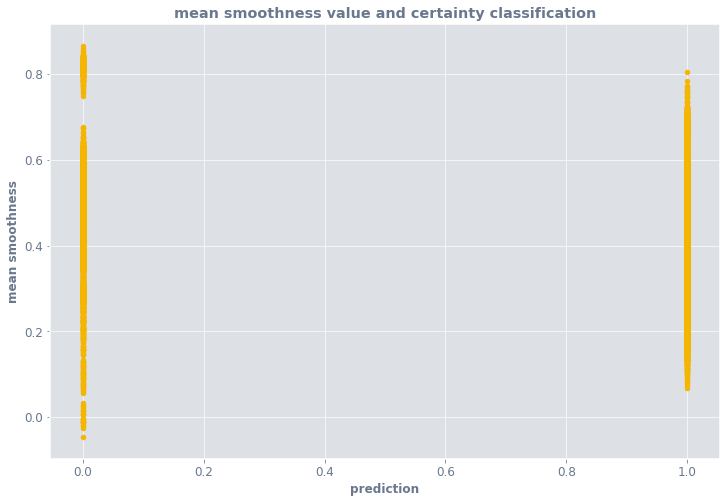

In [20]:
hd.density_scatter("mean smoothness")

In [21]:
hd.select_vis_cols(features, n_bins=25)

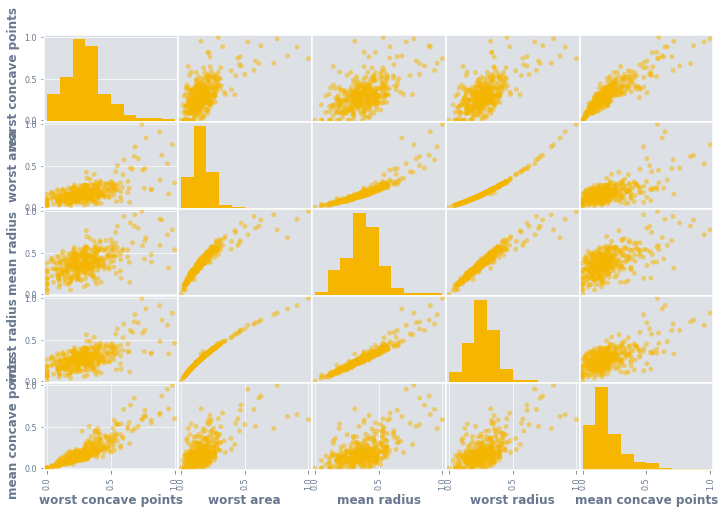

In [22]:
hd.scatter_plot_matrix(features)

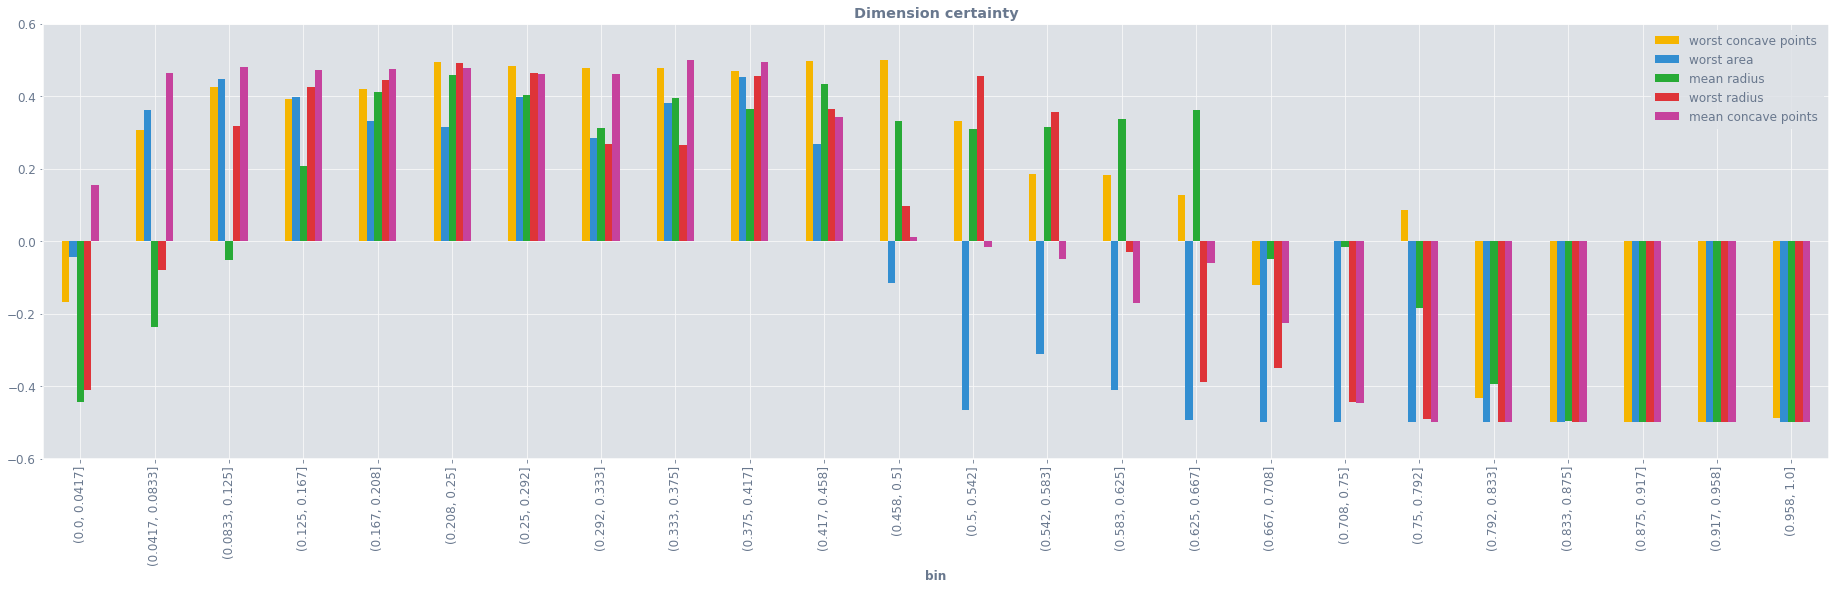

In [23]:
hd.vis_1d(figsize=(32, 8))

Red will be classified as within range of the classifier, while blue will be classified as outliers.

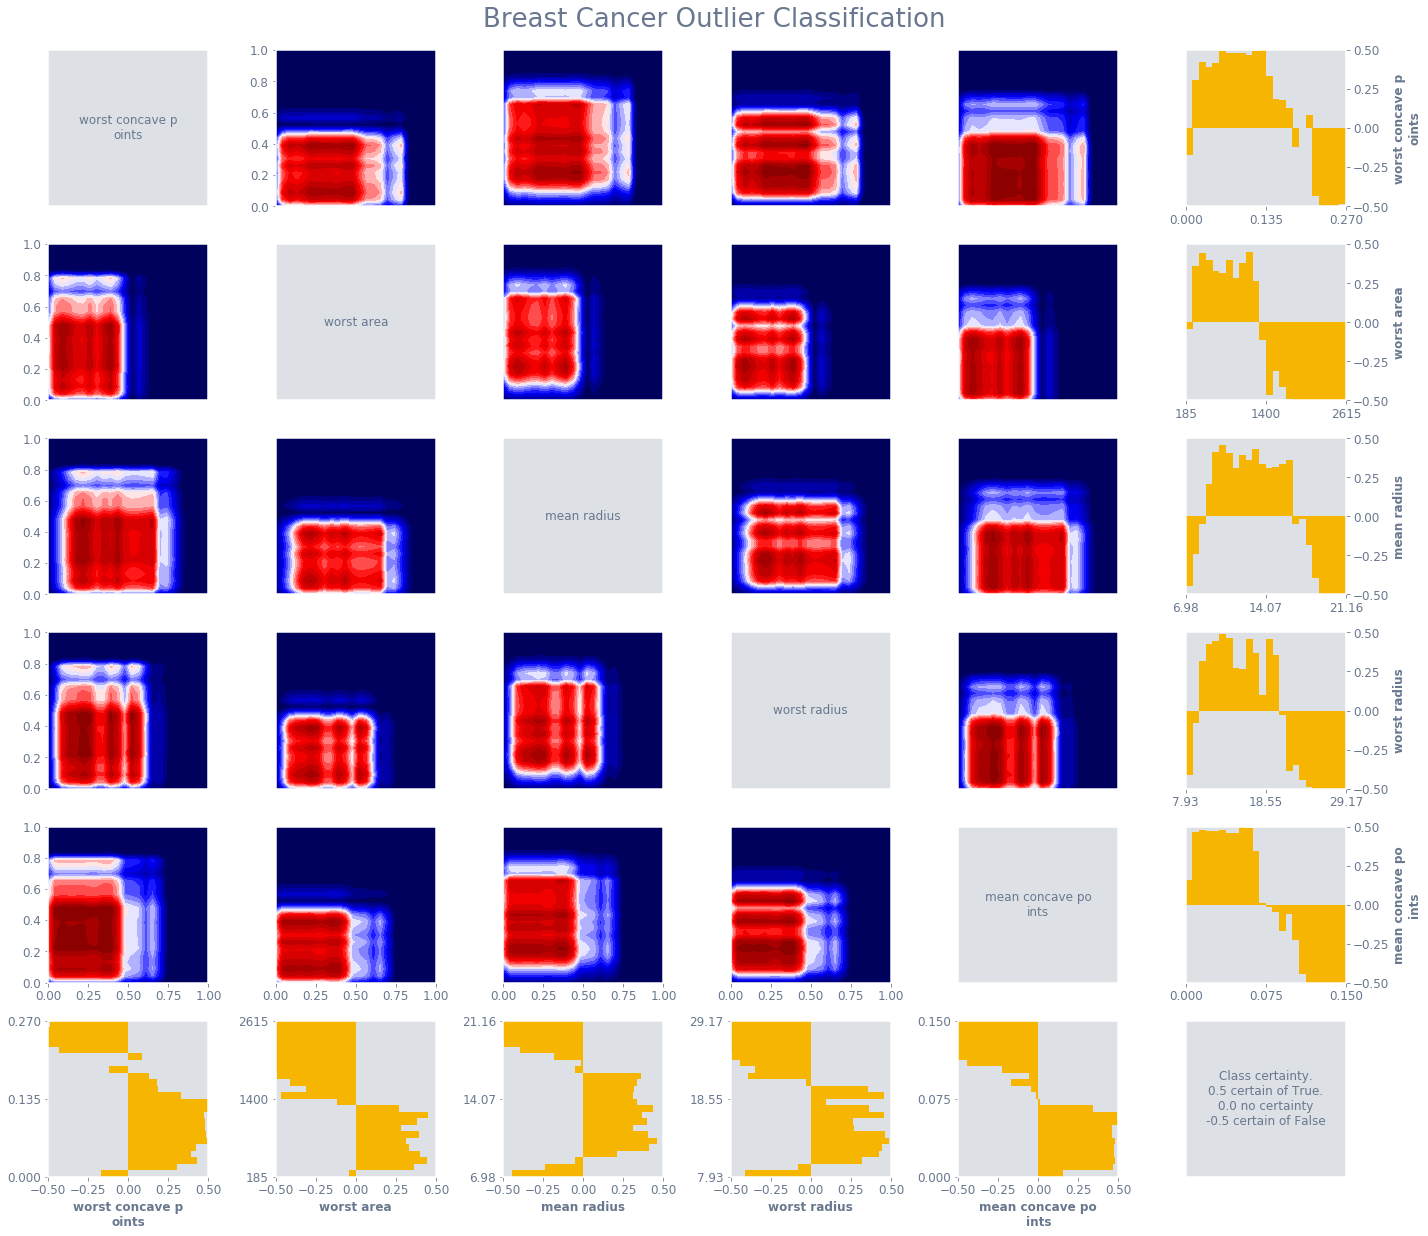

In [24]:
hd.vis_2d(title="Breast Cancer Outlier Classification")

## Random Forest Classifier and Outlier Detection Superposition

In [25]:
def oc_rf_clf_func(df):
    oc_pred = oc_clf_func(df)
    rf_pred = rf_clf_func(df)
    return [(rf_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [26]:
tst = oc_rf_clf_func(X_train[:30])
print(tst[:30])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.71, 0.0, 0.0, 0.07, 0.5, 0.030000000000000027, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.030000000000000027]


In [27]:
hd.density_estimate(oc_rf_clf_func, n=10000)

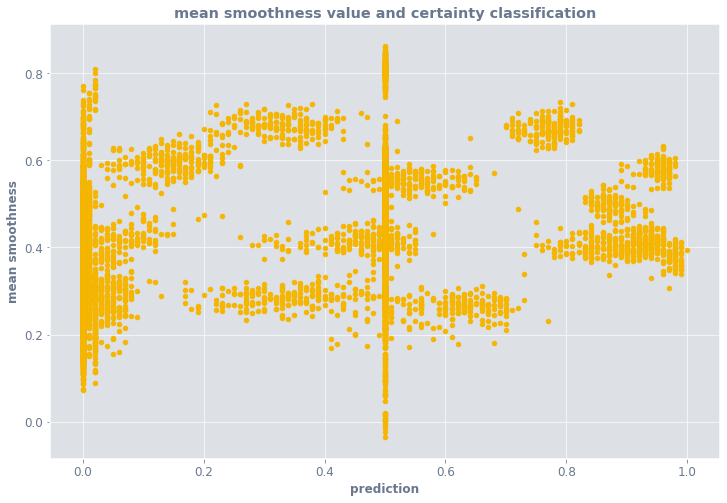

In [28]:
hd.density_scatter("mean smoothness")

In [29]:
hd.select_vis_cols(features, n_bins=25)

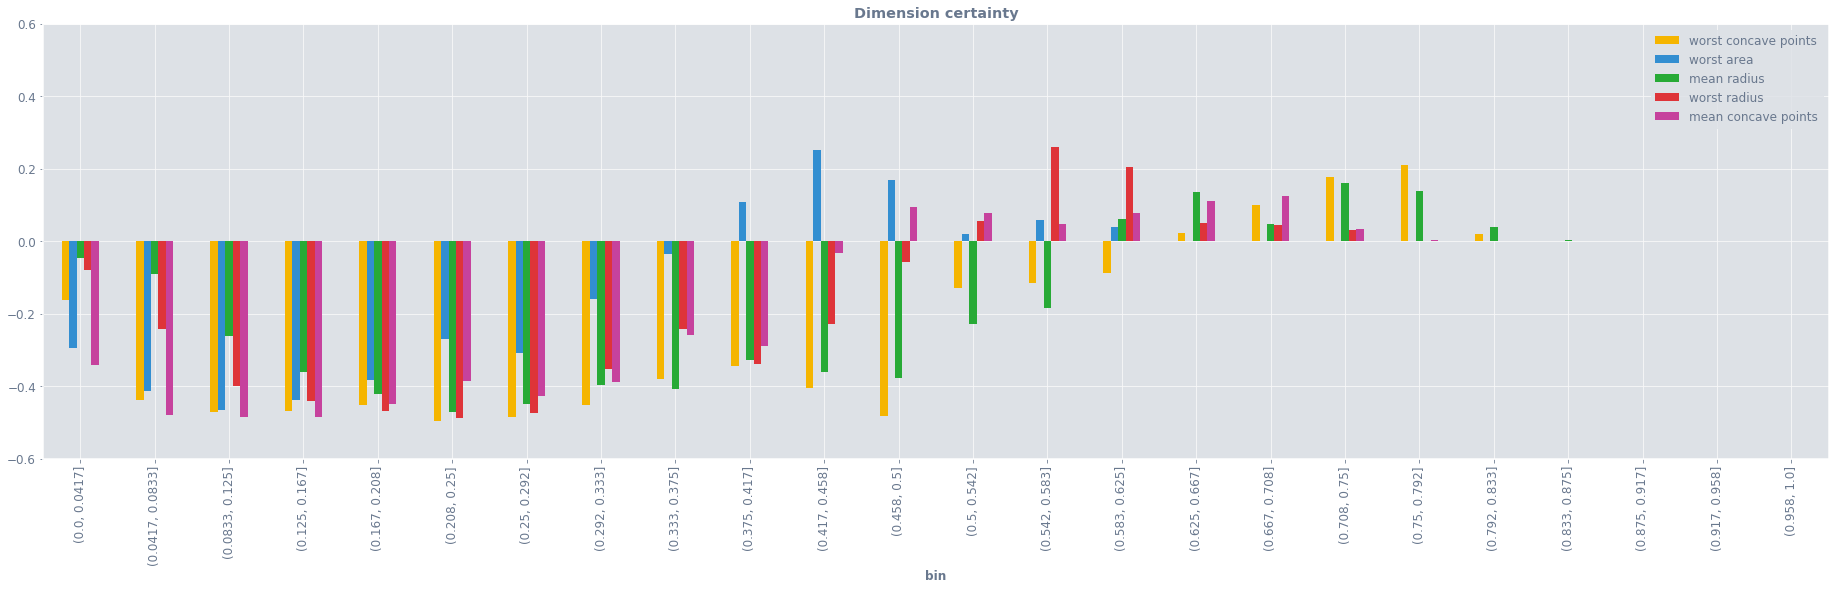

In [30]:
hd.vis_1d(figsize=(32, 8))

The areas where the classifier is uncertain have been superposed with the areas where samples are taken where training data is not present. The dark colours are strong indicates of good quality accross dimensions.

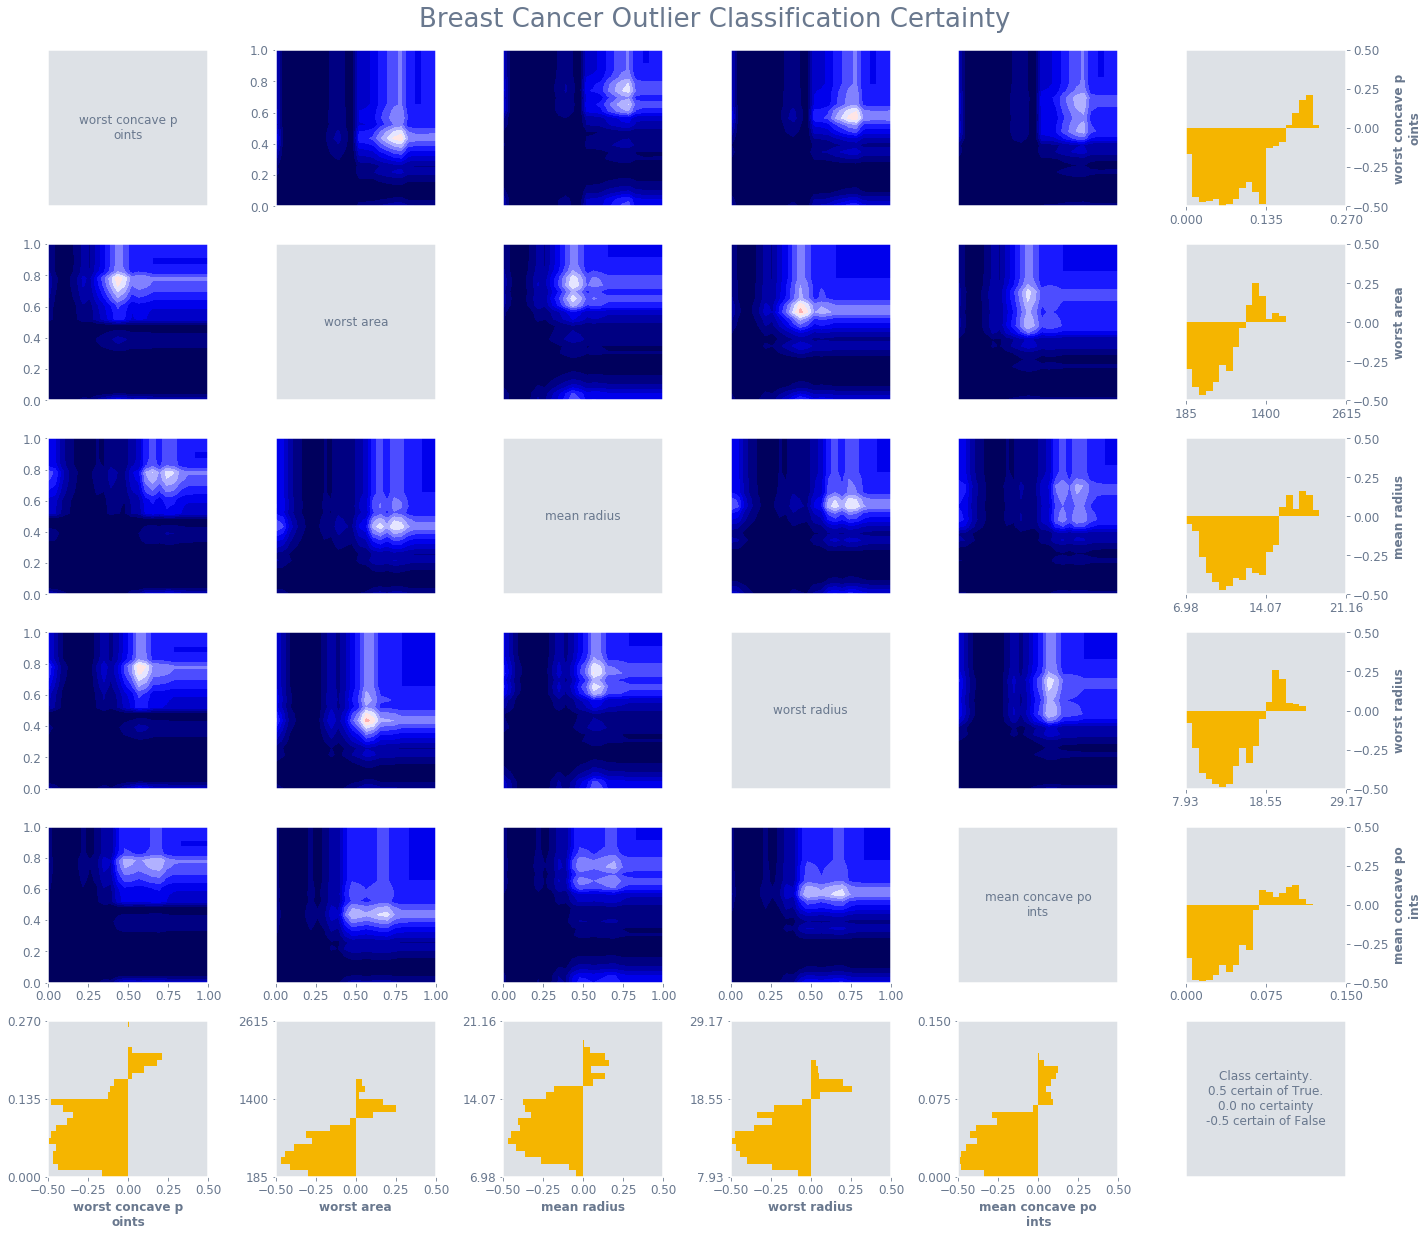

In [31]:
hd.vis_2d(title="Breast Cancer Outlier Classification Certainty")

## Neural Network

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 30 dimensions go in, 2 go out. The 2 coming out are the two
        # different classes available.
        self.fc1 = nn.Linear(X_train.shape[1], 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

    def predict(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([0 if i[0] > i[1] else 1 for i in pred])
    
    def predict_proba(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([i[1] / (i[0] + i[1]) for i in pred])

In [34]:
net = Net()

# Prepare data for neural network.
inputs = torch.FloatTensor(X_train.values)
labels = torch.LongTensor([1 if i == "malignant" else 0 for i in y_train])

# Optimizer to speed things up, cross entropy loss as it is a classifcation problem.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
epochs = 10000

losses = []
for epoch in range(epochs):
    outputs = net.forward(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("epoch:", epoch, "loss:", loss)
    
print('Finished Training ')

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0 loss: tensor(0.5801, grad_fn=<NllLossBackward>)
epoch: 1000 loss: tensor(0.2225, grad_fn=<NllLossBackward>)
epoch: 2000 loss: tensor(0.0130, grad_fn=<NllLossBackward>)
epoch: 3000 loss: tensor(0.0005, grad_fn=<NllLossBackward>)
epoch: 4000 loss: tensor(0.0002, grad_fn=<NllLossBackward>)
epoch: 5000 loss: tensor(7.2589e-05, grad_fn=<NllLossBackward>)
epoch: 6000 loss: tensor(3.6868e-05, grad_fn=<NllLossBackward>)
epoch: 7000 loss: tensor(1.9897e-05, grad_fn=<NllLossBackward>)
epoch: 8000 loss: tensor(1.1091e-05, grad_fn=<NllLossBackward>)
epoch: 9000 loss: tensor(6.3171e-06, grad_fn=<NllLossBackward>)
Finished Training 


Test NN accuracy.

In [35]:
test_input = torch.FloatTensor(X_test.values)
preds = np.array(net.predict(test_input))
test_labels = [1 if i == "malignant" else 0 for i in y_test]
print(preds)
print("F1 score:", f1_score(test_labels, preds, pos_label=1))
print("Confusion matrix:")
print(confusion_matrix(test_labels, preds))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
F1 score: 0.8799999999999999
Confusion matrix:
[[114   1]
 [  2  11]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The actual classifier function uses the raw certainty of the model.

In [36]:
preds = np.array(net.predict_proba(test_input))
for i in zip(preds, test_labels):
    print(i)

(6.2450596e-08, 0)
(6.798215e-08, 0)
(7.069861e-08, 0)
(8.5378076e-08, 0)
(0.00023279358, 0)
(7.000514e-08, 0)
(7.0303805e-08, 0)
(9.0853284e-08, 0)
(1.8555043e-07, 0)
(8.875173e-08, 0)
(1.05302036e-07, 0)
(7.586619e-08, 0)
(6.35554e-08, 0)
(2.2222052e-07, 0)
(6.240463e-08, 0)
(8.583822e-08, 0)
(7.193341e-08, 0)
(6.367309e-08, 0)
(1.431814e-07, 0)
(6.277184e-08, 0)
(6.238916e-08, 0)
(6.8283896e-08, 0)
(0.9999988, 1)
(3.1838664e-07, 0)
(0.99999845, 1)
(1.4747872e-07, 0)
(1.2705763e-07, 0)
(6.956073e-08, 0)
(0.9999993, 1)
(8.4560625e-08, 0)
(7.3296505e-08, 0)
(0.9999992, 1)
(6.593431e-08, 0)
(1.3342488e-07, 0)
(6.252091e-08, 0)
(0.25462076, 0)
(6.433818e-08, 0)
(2.18446e-06, 0)
(6.239297e-08, 0)
(9.040781e-08, 0)
(6.435463e-08, 0)
(6.290128e-08, 0)
(6.4512676e-08, 0)
(6.4176405e-08, 0)
(1.3807496e-06, 0)
(0.9999993, 1)
(6.354691e-08, 0)
(6.3905475e-08, 0)
(6.363157e-08, 0)
(2.7627636e-06, 0)
(6.245274e-08, 0)
(0.99998426, 0)
(9.736023e-08, 0)
(6.715964e-08, 0)
(6.256135e-08, 0)
(9.677924

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
# Certainty 
def nn_clf_func(df):
    test_tensor = torch.FloatTensor(df.values)
    return np.array(net.predict_proba(test_tensor))

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


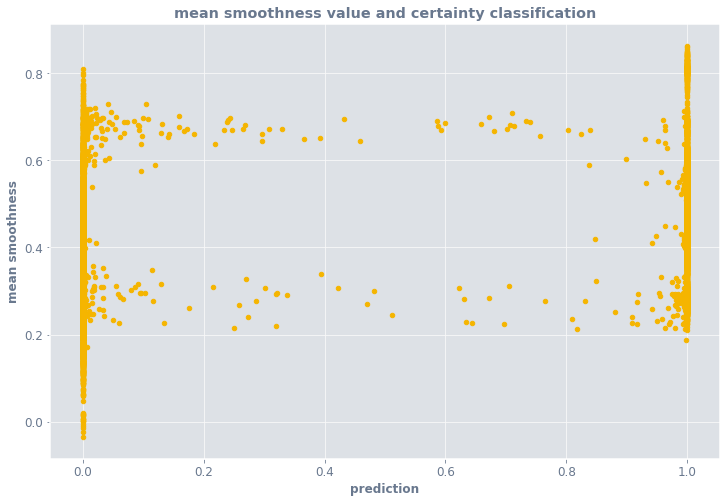

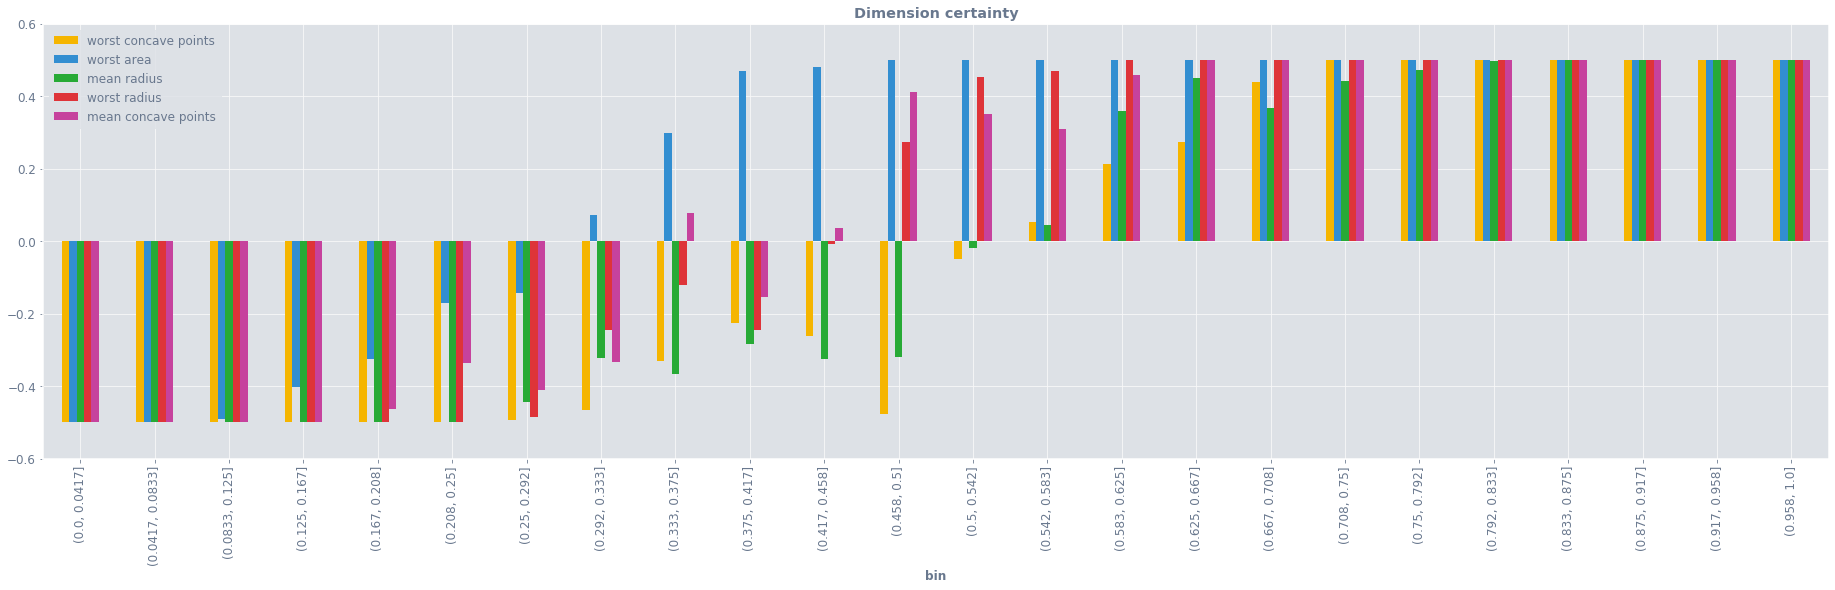

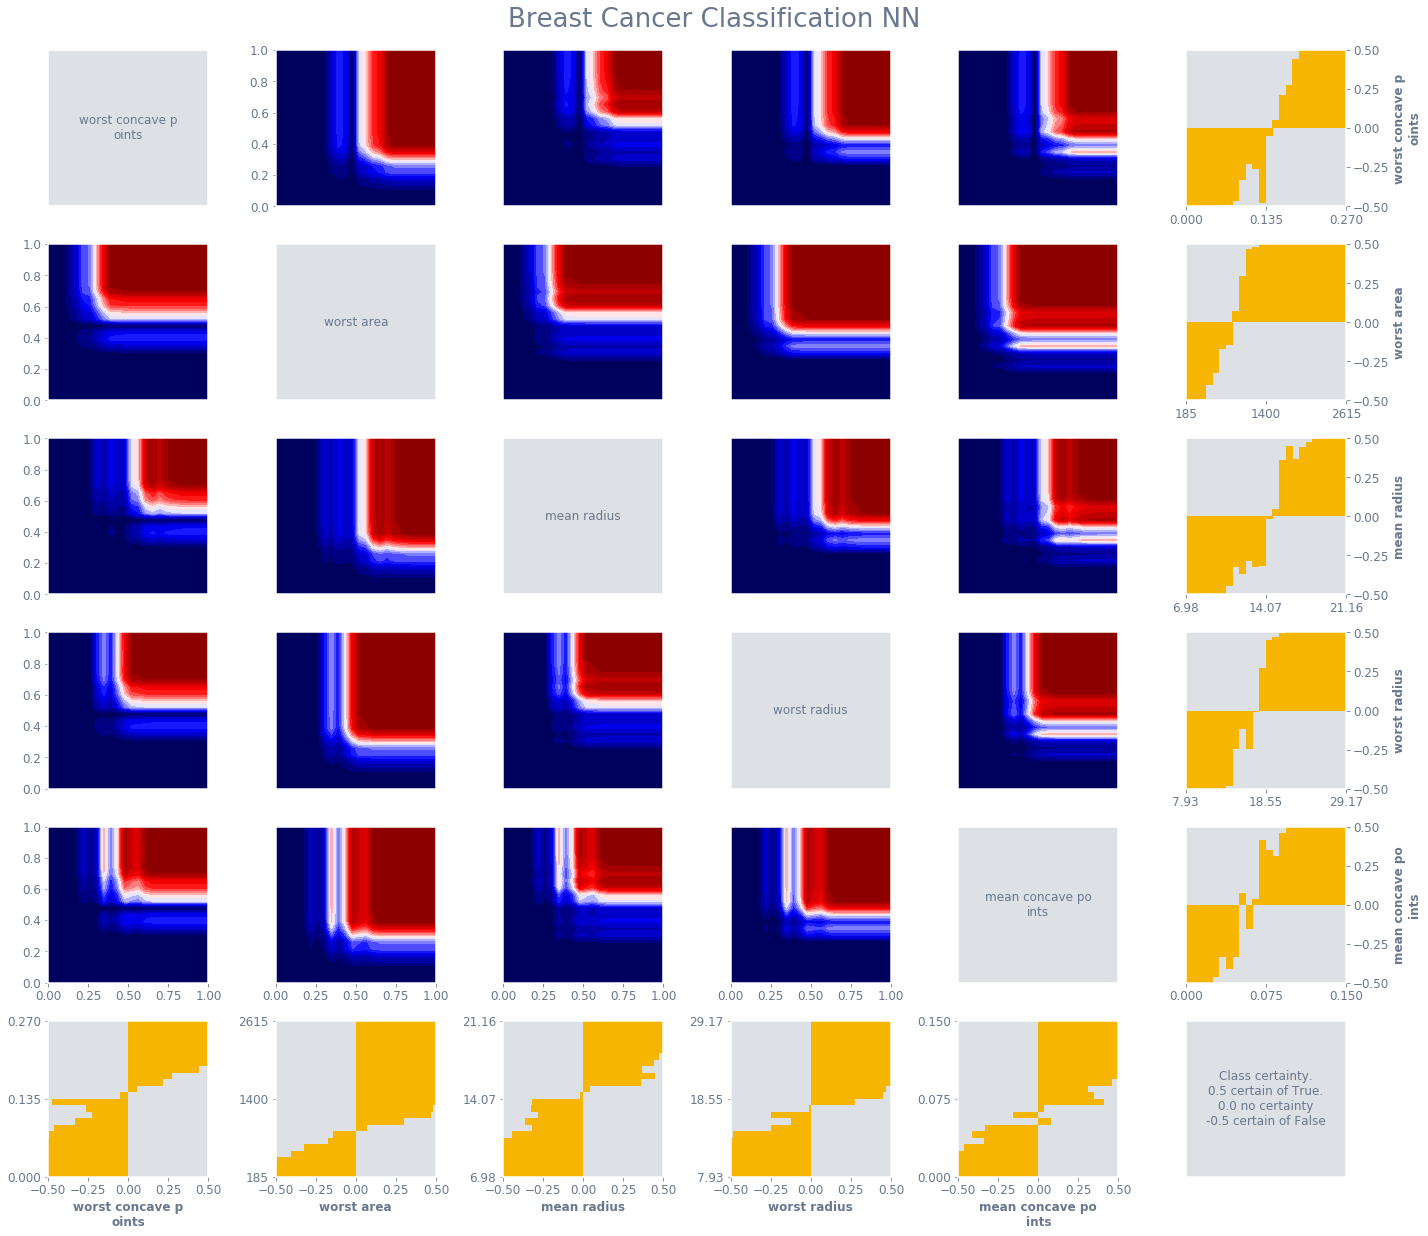

In [38]:
hd.density_estimate(nn_clf_func, n=10000)
hd.density_scatter("mean smoothness")
hd.select_vis_cols(features, n_bins=25)
hd.vis_1d(figsize=(32, 8))
hd.vis_2d(title="Breast Cancer Classification NN")

## NN Classifier and Outlier Detection Superposition

In [39]:
# Certainty 
def oc_nn_clf_func(df):
    oc_pred = oc_clf_func(df)
    nn_pred = nn_clf_func(df)
    return [(nn_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [40]:
tst = oc_nn_clf_func(X_train)
print(tst[:30])

[6.354242998440895e-08, 1.9265912953869702e-07, 7.018402925496048e-08, 8.875465573510155e-05, 6.248168915590213e-08, 6.62873773649153e-08, 7.391520995270184e-08, 6.477554848061118e-08, 1.85665624030662e-06, 7.127756873614999e-08, 1.0249300430587027e-05, 7.635569687636234e-08, 6.249444339800903e-08, 8.193114808818791e-08, 0.9999992251396179, 0.5, 7.545288838173292e-08, 0.9998131394386292, 4.331792240463983e-07, 6.600325974659427e-08, 9.712431165098678e-06, 0.5, 2.6680302767090325e-07, 6.381497996699181e-08, 0.5, 6.767966453935514e-08, 7.717754613167926e-08, 1.4234394996037736e-07, 9.82298260510106e-08, 6.825993636994099e-08]


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


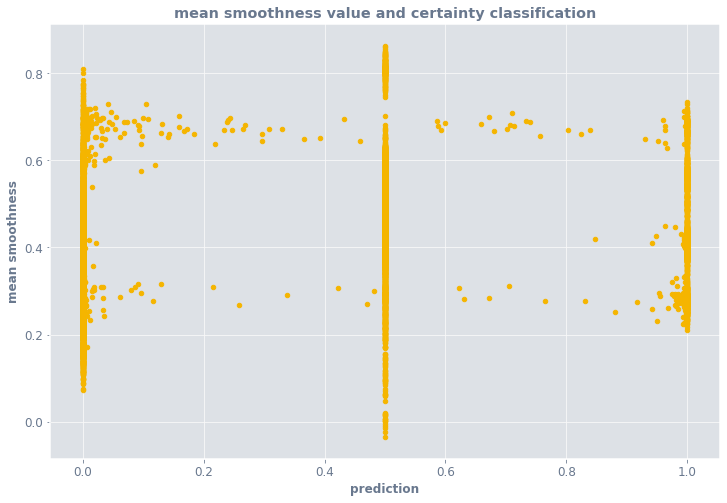

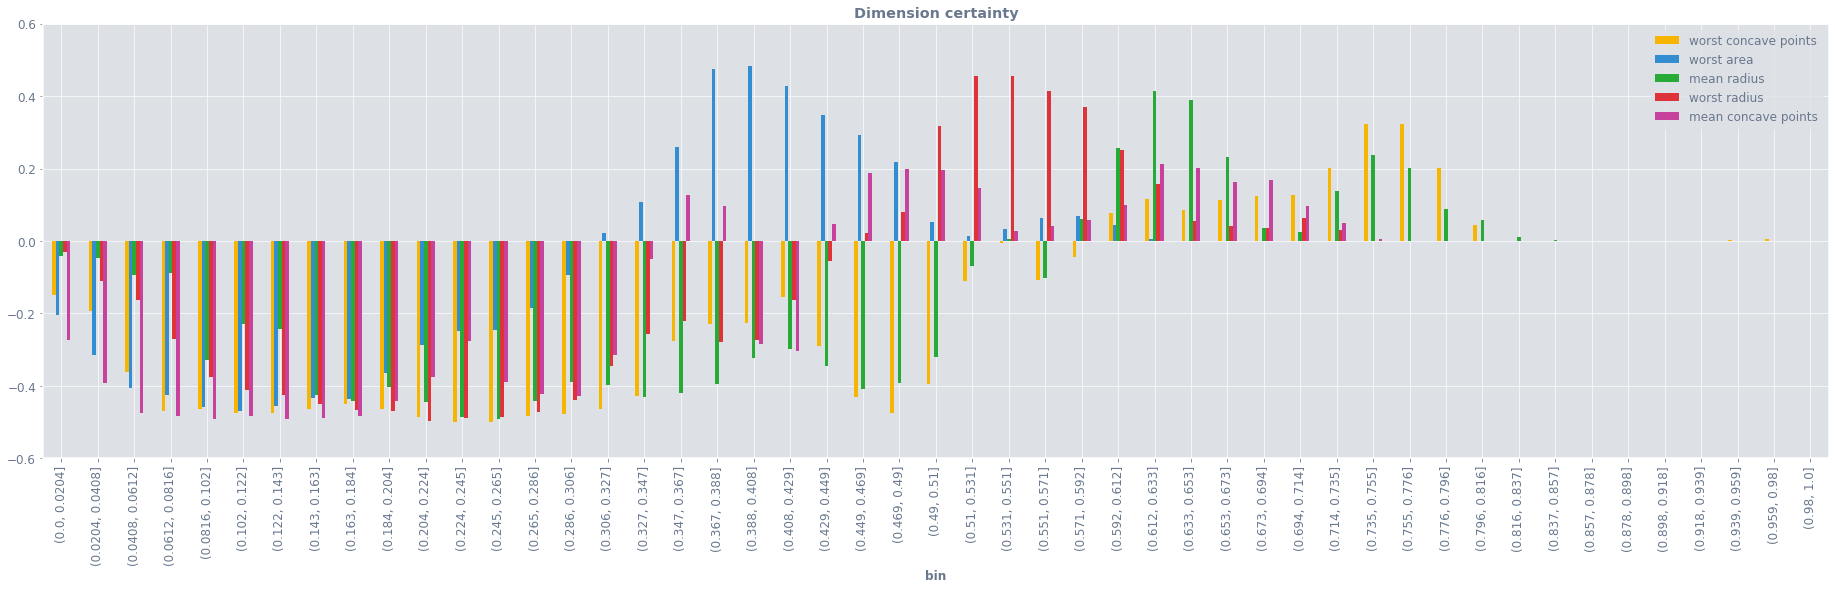

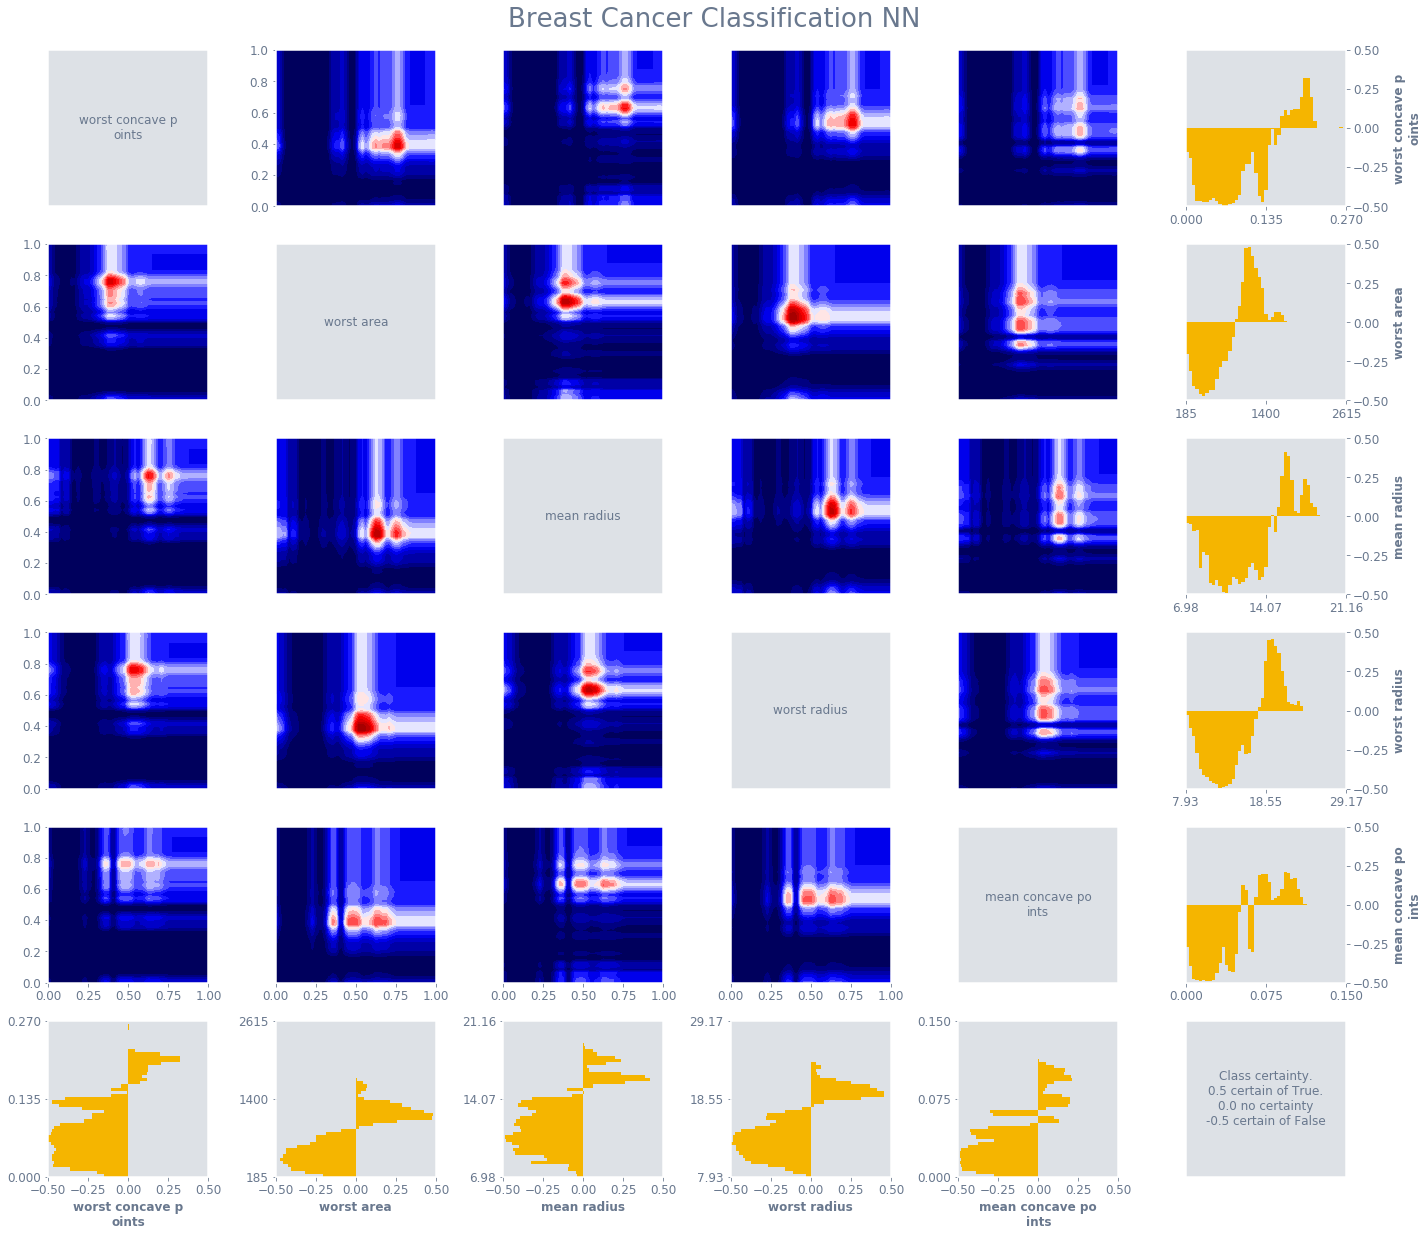

In [41]:
hd.density_estimate(oc_nn_clf_func, n=10000)
hd.density_scatter("mean smoothness")
hd.select_vis_cols(features, n_bins=50)
hd.vis_1d(figsize=(32, 8))
hd.vis_2d(title="Breast Cancer Classification NN")

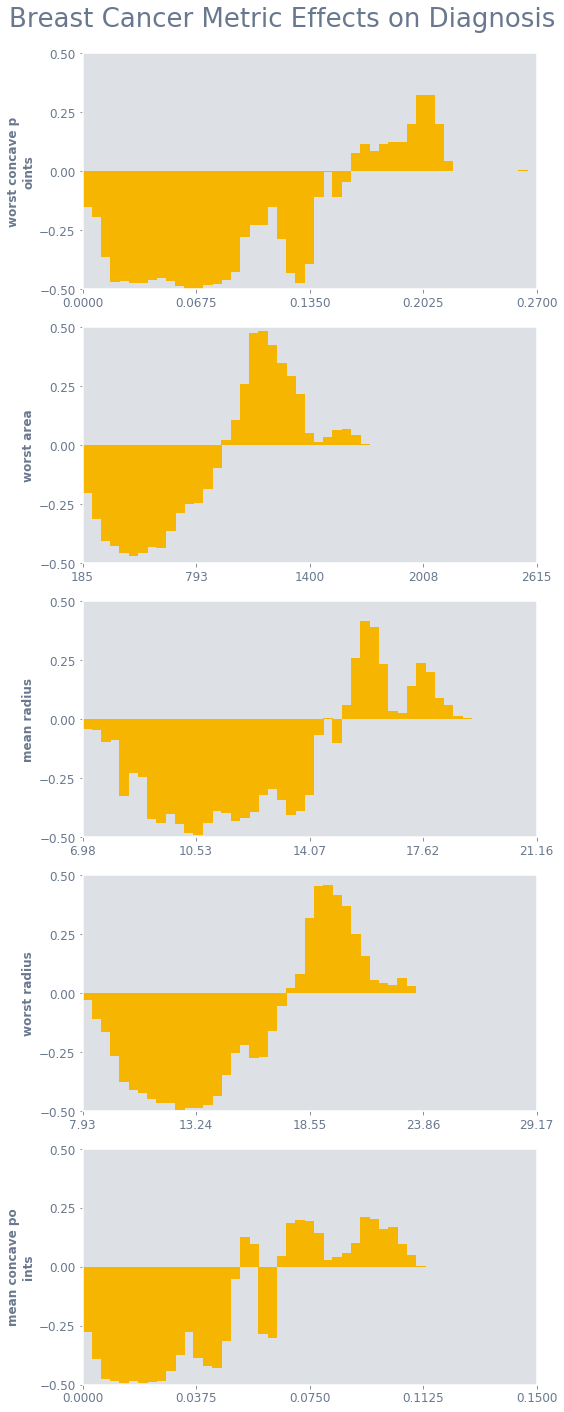

In [42]:
hd.vis_1d_separate("Breast Cancer Metric Effects on Diagnosis")